### Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# from catboost import CatBoostClassifier, Pool
import xgboost as xgb

#F1-Score Expectation Maximization in O(n^2)
#https://www.kaggle.com/mmueller/f1-score-expectation-maximization-in-o-n
#https://github.com/KazukiOnodera/Instacart/blob/master/py_model/opt_fscore.py

from f1optimization_faron import get_best_prediction

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , log_loss, f1_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
from tqdm import tqdm
import pickle


### Load Data

In [2]:
root = '/instacart-market-basket-analysis/'

data = pd.HDFStore("Data_v2.h5") #HDF5 format preserves data type after changing them

In [5]:
#accessing dataset using keys
train_data = data['train']
test_data  = data['test']

In [14]:
train_data["reordered"].value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

#### Utility Functions

In [132]:
def display_target_distribution(y_train, y_val):

  """
  Display target distribution in train and validation data
  """
  _, train_label_counts = np.unique(y_train, return_counts=True)
  _, val_label_counts = np.unique(y_val, return_counts=True)


  width = 0.35  # the width of the bars
  x = np.arange(2)
  fig, ax = plt.subplots(figsize=(12,6))
  rects1 = ax.bar(x - width/2, train_label_counts, width, label='Train')
  rects2 = ax.bar(x + width/2, val_label_counts, width, label='validation')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Number of datapoints')
  ax.set_title('Distribution of the Output Variable')
  ax.set_xticks(x)
  ax.set_xticklabels([0,1])
  ax.legend()
  plt.show()

def random_split(test_size = 0.1):

  """
  Split data randomly into train and validation data 
  """
  train_y = train_data['reordered'].values.tolist()
  train_x = train_data.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  # since there are Millions of data ,we are taking 10% of data in test set , 
  X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.1, random_state = 42)

  #display distribution of data
  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)

def split_by_user(test_size = 0.1):
  
  #split on users
  sampled_users = train_data['user_id'].sample(n=int(0.1 * train_data['user_id'].nunique()), random_state=42,replace=False).reset_index()
  val = train_data[train_data['user_id'].isin(sampled_users['user_id'].tolist())]
  train = train_data[~train_data['user_id'].isin(sampled_users['user_id'].tolist())]

  y_train = train['reordered'].values.tolist()
  X_train = train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  y_val = val['reordered'].values.tolist()
  X_val = val.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)

In [133]:
def model_stats(predict_y,y_val):# Plot confusion Matrix

  """
  Display model statistics such as accuracy , precision score and confusion matrix
  """

  #predicted_y =np.array(predict_y>0.5,dtype=int).reshape(-1,).tolist()
  cm = confusion_matrix(y_val, predict_y)
  sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
  plt.show()
  print("Accuracy :",accuracy_score(y_val, predict_y))
  print("Precision :",precision_score(y_val, predict_y))

#### Function to create submission file based on 3 different global threshold

In [134]:
def convert_to_string(row):
    """
    convert series value to list of strings
    """
    list_string = list(map(str, row.tolist())) # convert series > list > list of strings
    return " ".join(list_string)

def globl_threshold_products(model = None, scaler = None, model_type = 'xgb', val_file="Data_v2.h5"):

    """
    Get all products above threshold and join them
    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    #if model is xgb use model.predict(), else use model.predict_proba()
    if model_type == 'xgb':
      dtest = xgb.DMatrix(data)
      ypred = model.predict(dtest)
    
    elif model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()

    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred

    #create a dataframe wiith unique order id
    df = pd.DataFrame({'order_id':test_data['order_id'].unique()})

    # 3 best threshold values based on multiple runs
    for i, thresh in enumerate([0.18,0.19,0.20]):

      #get all products above threshold and join them 
      test_data_copy = test_data[test_data['reordered']>=thresh].groupby(['order_id'])['product_id'].apply(convert_to_string).reset_index(name = "products")
      
      #create a submission by merging the order_id with test_data_copy
      submission = pd.merge(test_data_copy,df, on = 'order_id', how = 'right')
      submission['order_id'] = submission['order_id'].apply(int)

      # replace empty cells with None , where no product is above threshold probability
      submission = submission.where(pd.notnull(submission), None)

      #save submission file
      submission.to_csv("submission_sample_v8_{}_{}.csv".format(i+1,model_type), index= False)
      print("Generated submission_sample_v8_{}_{}.csv successfully".format(i+1,model_type))

##### Function to return product list which maximizes F1-score ( uses faron's kernel)

In [135]:
def getscores_on_testdata(model = None ,scaler = None, model_type = 'xgb', val_file = "Data_v2.h5"):
    """
    Returns product list for every order-ID which maximizes F1-score
    
    Parameters
    ----------
    model      : The default is None.
                 Trained model is passed here  
    model_type : The default is xgb
                 Identifier to deal with both sgb and catboost models
    val_file   : The default is Data_v2.h5
                 Path of dataset is passed
    Returns
    -------
    test_products : Dataframe object
                  This dataframe contains orderID, productID's(string)

    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    #if model is xgb use model.predict(), else use model.predict_proba()
    if model_type == 'xgb':
      dtest = xgb.DMatrix(data)
      ypred = model.predict(dtest)
    
    elif model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()
    
    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred
    
    #create a dataframe with orderID and list of all possible productID's
    test_products = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
    
    #collect all probs in a single list for each OrderID
    probs = test_data.groupby(['order_id'])['reordered'].apply(list).reset_index()
    test_products['probs'] = probs['reordered']

    #run faron's optimization code to get most probable set of products which might be reordered
    products = []
    for i in tqdm(test_products.index):
        prods = get_best_prediction(test_products.iloc[i]['product_id'], test_products.iloc[i]['probs'], None)
        products.append(prods)

    test_products['products']= products
    
    test_products['order_id'] = test_products['order_id'].apply(int)
    test_products.drop(['product_id','probs'], axis = 1, inplace = True)
   
    return test_products
    

## Models

### Logistic Regression

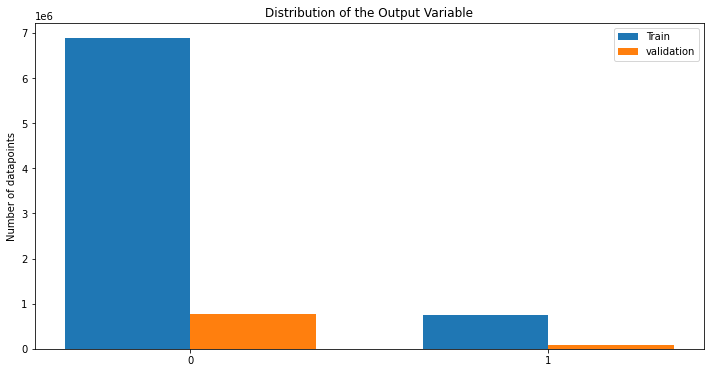

In [136]:
#data split randomly

(X_train, y_train),(X_val, y_val) = random_split(test_size = 0.1)

In [137]:
# fit scaler on training data
scaler = StandardScaler().fit(X_train)

# transforming the data
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)

logloss on validation data : 0.2550918280106341


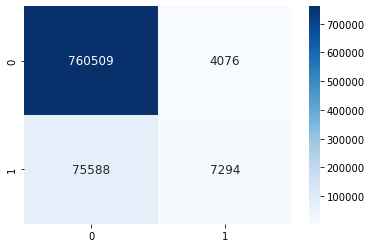

Accuracy : 0.9059975196674325
Precision : 0.6415127528583993
Wall time: 3min 4s


In [14]:
%%time

log_reg = LogisticRegression(random_state=0, n_jobs = -1)
log_reg.fit(X_train_norm,y_train)

predict_y = log_reg.predict_proba(X_val_norm)
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
model_stats(np.argmax(predict_y,1),y_val)

### Decision Tree

In [15]:
%%time
param_grid = {}
param_grid['max_depth'] = [5,10,15,20]
param_grid['min_samples_split'] = [2,3,4,5]

dt_clf = DecisionTreeClassifier()
r_search = RandomizedSearchCV(dt_clf, param_distributions=param_grid, cv = 5, verbose = True, n_jobs = -1)
r_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1h 9min 14s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_split': [2, 3, 4, 5]},
                   verbose=True)

In [16]:
r_search.best_params_

{'min_samples_split': 2, 'max_depth': 10}

logloss on validation data : 0.250868235017748


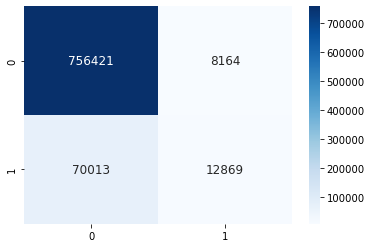

Accuracy : 0.9077521602611075
Precision : 0.6118480483050445


In [17]:
predict_y = r_search.predict_proba(X_val)
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
model_stats(np.argmax(predict_y,1),y_val)

### Random Forest

##### When to calibrate your model ?
ref: https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

logloss on validation data : 0.2518767530530419


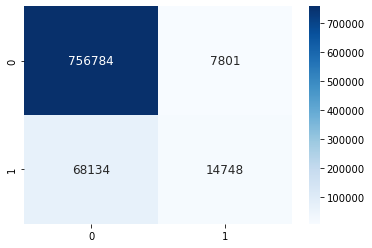

Accuracy : 0.9103976910015376
Precision : 0.6540423078628764
Wall time: 1h 1min 42s


In [18]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=25,random_state=42,n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_val)
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
model_stats(np.argmax(predict_y,1),y_val)

### Multi Layer Perceptron Model

In [106]:
## import tensorflow packages
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Input,Activation,Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

#SEED
SEED_VALUE = 0
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [22]:
def mlp_model():
    """
    Create mlp model with 4 hidden layers .
    """
    inp = Input(shape =  (28,)) #no of features
    mlp = Dense(256, activation = "relu", kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_1')(inp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(128, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_2')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(64, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_3')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_4')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_5')(mlp)

    model = Model(inputs = inp, outputs = mlp)
    
    opt = Adam(lr= 0.001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [23]:
import os

#save model checkpoint
filepath="checkpoint.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1)

In [24]:
tf.keras.backend.clear_session()

model = mlp_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 fc_1 (Dense)                (None, 256)               7424      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 fc_3 (Dense)                (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

C:\Users\kati-silas\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
#train model
batch_size = 128
history = model.fit(X_train_norm,np.array(y_train).reshape(-1,1), epochs = 10, validation_data = (X_val_norm,np.array(y_val).reshape(-1,1)), callbacks=[checkpoint, earlystop])

Epoch 1/10
238343/238350 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.9045
Epoch 00001: val_accuracy improved from 0.90684 to 0.90757, saving model to checkpoint.hdf5
238350/238350 [==============================] - 706s 3ms/step - loss: 0.2617 - accuracy: 0.9045 - val_loss: 0.2536 - val_accuracy: 0.9076
Epoch 2/10
238346/238350 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9042
Epoch 00002: val_accuracy did not improve from 0.90757
238350/238350 [==============================] - 686s 3ms/step - loss: 0.2632 - accuracy: 0.9042 - val_loss: 0.2573 - val_accuracy: 0.9057
Epoch 3/10
238347/238350 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.9041
Epoch 00003: val_accuracy did not improve from 0.90757
238350/238350 [==============================] - 661s 3ms/step - loss: 0.2642 - accuracy: 0.9041 - val_loss: 0.2513 - val_accuracy: 0.9070
Epoch 00003: early stopping


In [31]:
#load the saved model and print accuracy

saved_model = tf.keras.models.load_model('checkpoint.hdf5')
print("Training Accuracy :{:.2f} %".format(saved_model.evaluate(X_train_norm,np.array(y_train).reshape(-1,1), verbose = 0)[1]*100))
print("Validation Accuracy :{:.2f} %".format(saved_model.evaluate(X_val_norm,np.array(y_val).reshape(-1,1), verbose = 0)[1]*100))

Training Accuracy :90.76 %
Validation Accuracy :90.76 %


logloss on validation data : 0.2535987016498708


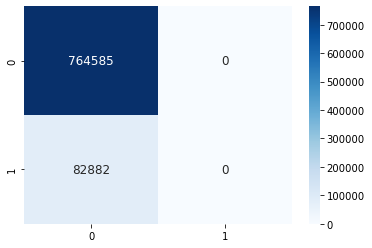

Accuracy : 0.9022003216644424
Precision : 0.0


C:\Users\kati-silas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
#print model statistics

predict_y = saved_model.predict(X_val_norm)
print("logloss on validation data :",log_loss(y_val, predict_y.reshape(-1,).tolist(), labels=[0,1], eps=1e-15))
# model_stats(predict_y,y_val)
model_stats(np.argmax(predict_y,1),y_val)

### Performance

We will compare all models for their mean f1-score on test set , on both global threshold and local threshold

In [37]:
from prettytable import PrettyTable
# http://zetcode.com/python/prettytable/

x = PrettyTable()
x.field_names = ["Model", "logloss", "Threshold " , "Private Score" ,"Public Score"]
x.add_row(['Logistic Regression','0.2550','Global_Threshold : 0.18','0.35316','0.35485'])
x.add_row(['Logistic Regression','0.2550','Local_Threshold : faron_opt','0.37405','0.37687'])
x.add_row(['Decision Tree Classifier','0.2509','Global_Threshold : 0.20','0.28438', '0.28660'])
x.add_row(['Decision Tree Classifier','0.2509','Local_Threshold : faron_opt','0.29532', '0.29822'])
x.add_row(['Random Forest Classifier','0.2518','Global_Threshold : 0.18','0.35359','0.35456'])
x.add_row(['Random Forest Classifier','0.2518','Local_Threshold : faron_opt','0.37825','0.38067'])
x.add_row(['MLP model','0.2434','Global_Threshold : 0.18','0.35598','0.35630'])
x.add_row(['MLP model','0.2434','Local_Threshold : faron_opt','0.38327','0.38449'])

print(x)

+--------------------------+---------+-----------------------------+---------------+--------------+
|          Model           | logloss |          Threshold          | Private Score | Public Score |
+--------------------------+---------+-----------------------------+---------------+--------------+
|   Logistic Regression    |  0.2550 |   Global_Threshold : 0.18   |    0.35316    |   0.35485    |
|   Logistic Regression    |  0.2550 | Local_Threshold : faron_opt |    0.37405    |   0.37687    |
| Decision Tree Classifier |  0.2509 |   Global_Threshold : 0.20   |    0.28438    |   0.28660    |
| Decision Tree Classifier |  0.2509 | Local_Threshold : faron_opt |    0.29532    |   0.29822    |
| Random Forest Classifier |  0.2518 |   Global_Threshold : 0.18   |    0.35359    |   0.35456    |
| Random Forest Classifier |  0.2518 | Local_Threshold : faron_opt |    0.37825    |   0.38067    |
|        MLP model         |  0.2434 |   Global_Threshold : 0.18   |    0.35598    |   0.35630    |


For Local threshold :

Catboost > XGB > MLP > Random forest > Logistic Regression > Decision Tree

For Global threshold:

Catboost > XGB > MLP > Random forest > Logistic Regression > Decision Tree

### Change .csv to .pkl

In [46]:
def file_convert(filename):
    file = pd.read_csv(os.getcwd() + '\\' + filename + '.csv')
    file.to_pickle(filename + '.pkl')

In [47]:
file_convert("hour_reorder_rate")
file_convert("day_reorder_rate")
file_convert("p_days_since_prior_order_reorder_rate")
file_convert("u_days_since_prior_order_reorder_rate")
file_convert("days_since_prior_reorder_rate")

### Final function to return product recommendation

In [127]:
def get_recommendations(X = None):


    start_time = datetime.now()

    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    today = int(dt_string.split("/")[0])

    #get data from user end
    user_id = int(X['user_id']) #user_id
    order_hour_of_day = int(dt_string.split(" ")[1].split(":")[0]) #current date
    order_dow = datetime.today().weekday() #current day of week




    ulp = pd.read_pickle("user_last_purchase.pkl")
    if user_id not in ulp['user_id'].values:

        #get top 5 products based on hour of day and day of week
        top= pd.read_pickle('top10_products.pkl')
        top_products = top[(top['order_dow']==order_dow) & (top['order_hour_of_day']==order_hour_of_day)]['product_name'].values.tolist()
        top_products = {i: value for i,value in enumerate(top_products)}
        #paths = get_image_paths(top5_products)
        predictions={}
        predictions['top'] =  top_products

        del ulp, top,now, today, dt_string, order_dow, order_hour_of_day

        end_time = datetime.now()
        difference = end_time - start_time
        #print("Total Time : {} seconds".format(difference))
        time = "{}".format(difference)

        return predictions,time

    user_last_order_date = ulp[ulp['user_id']==user_id]['date'].values.tolist()[0]

    days_since_prior_order = today - int(user_last_order_date.split('-')[-1])
    
    del ulp, now, today, dt_string, user_last_order_date
    #featurization

    hour_rate = pd.read_pickle("hour_reorder_rate.pkl")
    day_rate = pd.read_pickle("day_reorder_rate.pkl")
    p_days_rate = pd.read_pickle("p_days_since_prior_order_reorder_rate.pkl")
    u_days_rate = pd.read_pickle("u_days_since_prior_order_reorder_rate.pkl")
    up_days_rate = pd.read_pickle("days_since_prior_reorder_rate.pkl")

    merged_up_features = pd.read_pickle("train_orders_merged_df_v6.pkl")

    featurized_data = merged_up_features[merged_up_features['user_id']==user_id]

    hour_r = hour_rate[hour_rate['order_hour_of_day']==order_hour_of_day]
    day_r = day_rate[day_rate['order_dow'] == order_dow]
    p_days = p_days_rate[p_days_rate['days_since_prior_order']==days_since_prior_order]
    u_days = u_days_rate[(u_days_rate['user_id']==user_id) & (u_days_rate['days_since_prior_order']==days_since_prior_order)]
    
    
    if p_days.empty:
        #handle
        p_days = pd.DataFrame(columns = p_days.columns)
        products_x = pd.read_pickle('product_mappings.pkl')
        p_days['product_id'] = products_x['product_id']
        p_days['days_since_prior_order'] = days_since_prior_order
        p_days['p_days_since_prior_order_reorder_rate']=0.0
    
    if u_days.empty:
        #handle
        u_days = pd.DataFrame(columns = u_days.columns)
        df2 = {'user_id': user_id, 'days_since_prior_order': days_since_prior_order,
               'u_days_since_prior_order_reorder_rate': 0.0}
        u_days = u_days.append(df2, ignore_index = True)
        del df2
        

    up_days = up_days_rate[(up_days_rate['user_id']==user_id) & 
                           (up_days_rate['days_since_prior_order']==days_since_prior_order)]

    if up_days.empty:
        #handle
        up_days = pd.DataFrame(columns = up_days_rate.columns)
        products_x = pd.read_pickle('product_mappings.pkl')
        up_days['product_id'] = products_x['product_id']
        up_days['user_id'] = user_id
        up_days['days_since_prior_order'] = days_since_prior_order
        up_days['days_since_prior_reorder_rate']=0
        del products_x


    #print("UP_DAYS_RATE: ", up_days_rate[up_days_rate['user_id']==user_id])
    #print(u_days_rate[u_days_rate['user_id']==user_id])
    #print(day_rate)
    del merged_up_features, hour_rate, day_rate, p_days_rate, u_days_rate, up_days_rate

    featurized_data = pd.merge(featurized_data, up_days, how='left', on = ['user_id', 'product_id'], suffixes=(None, '_y'))

    featurized_data = pd.merge(featurized_data, hour_r, how='left', on = 'product_id', suffixes=(None, '_y'))
    featurized_data = pd.merge(featurized_data, day_r, how='left', on = 'product_id', suffixes=(None, '_y'))
    featurized_data = pd.merge(featurized_data, p_days, how='left', on = ['product_id','days_since_prior_order'], suffixes=(None, '_y'))
    featurized_data = pd.merge(featurized_data, u_days, how='left', on = ['user_id','days_since_prior_order'], suffixes=(None, '_y'))
    featurized_data = featurized_data[['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate',
                                       'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate',
                                       'user_unique_products', 'user_total_products', 'user_avg_cart_size',
                                       'user_avg_days_between_orders', 'user_reordered_products_ratio',
                                       'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2',
                                       'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate',
                                       'dept_reorder_rate', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
                                       'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate',
                                       'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']]

    del up_days,u_days,p_days,day_r,hour_r

    #model
    model = tf.keras.models.load_model('checkpoint.hdf5')
    
    data = featurized_data.drop(['user_id', 'product_id'], axis = 1)
    
    # fit scaler on training data
    scaler = StandardScaler().fit(data)

    # transforming the data
    data_norm = scaler.transform(data)
    
    ypred = model.predict(data_norm)
    ypred = ypred[:,-1] #get probabilities of class 1
    del data,model

    #run faron's optimization code to get most probable set of products which might be reordered
    
    #set showThreshold = True , while debugging to print the threshold
    recommended_products = get_best_prediction(featurized_data['product_id'].tolist(), ypred.tolist(), None, showThreshold = True)
    recommended_products = recommended_products.replace("None", "")
    recommended_products = list(map(int, recommended_products.split()))
    products_x = pd.read_pickle('product_mappings.pkl')
    recommended_products = products_x.loc[products_x['product_id'].isin(recommended_products)]['product_name'].values.tolist()
    recommended_products = {i: value for i,value in enumerate(recommended_products)}

    predictions= {}
    predictions['recommend'] = recommended_products

    end_time = datetime.now()
    difference = end_time - start_time
    #print("Total Time : {} seconds".format(difference))
    time = "{}".format(difference)

    del featurized_data, products_x
    return predictions, time

In [128]:
#existing user

X = {}
X['user_id'] = 5
recommended_products = get_recommendations(X)

print()
print("="*20)
print("Recommended products")
print("="*20)
for _,value in recommended_products[0]['recommend'].items():
    print(value)

Threshold : P(X) > 0.3882
Maximum F1 : 0.6466

Recommended products
Organic Red Onion
Red Raspberries
Snow Peas
Organic Soba
Plain Whole Milk Yogurt
Organic Blackberries
Organic Grape Tomatoes
Whole Vitamin D Milk


In [129]:
#existing user

X = {}
X['user_id'] = 55
recommended_products = get_recommendations(X)

print()
print("="*20)
print("Recommended products")
print("="*20)
for _,value in recommended_products[0]['recommend'].items():
    print(value)

Threshold : P(X) > 0.4986
Maximum F1 : 0.7662

Recommended products
Imported Mineral Water
Organic Bunny Fruit Snacks Berry Patch
Chocolate Peppermint Stick Bar
Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
Organic Summer Strawberry Bunny Fruit Snacks
Goldfish Cheddar Baked Snack Crackers
Organics Chocolate Milk with DHA
Original Whipped Cream Cheese
Organic Uncured Sliced Black Forest Ham
Pirate's Booty Aged White Cheddar Baked Rice and Corn Puffs
Plain Mini Bagels
Grape White/Green Seedless


In [33]:
#new user

X = {}
X['user_id'] = 225000
recommended_products = get_recommendations(X)

print()
print("="*20)
print("Recommended products")
print("="*20)
for _,value in recommended_products[0]['top'].items():
    print(value)


Recommended products
Banana
Bag of Organic Bananas
Organic Baby Spinach
Organic Strawberries
Organic Hass Avocado
Organic Avocado
Large Lemon
Limes
Organic Yellow Onion
Organic Garlic
